<a href="https://colab.research.google.com/github/edivet92/NLP/blob/edivet92-patch-6/Egorov_Denis_NLP_HW_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Практическое задание 12

Реализовать суммаризацию текста


In [1]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [2]:
!pip install razdel networkx nltk summa sumy
!pip install --upgrade datasets razdel spacy networkx seaborn scipy tqdm tensorflow-text
!python -m spacy download ru_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 90.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54389 sha256=f4e72293acd6a958f8ca650af01faecadfaafea2d11d03ade09f7b122a750e5a
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21694 sha256=5a5c375ee7c010ca3e0e4caeb16fca4538855746f8303664a225e700f4421d83
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41

In [3]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 24.7 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset

dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")["test"]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

In [5]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [7]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [8]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [8]:
test_records[0]

{'url': 'https://www.gazeta.ru/science/2020/02/14_a_12960289.shtml',
 'text': 'Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, к

In [9]:
train_records[0].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date'])

In [10]:
print(min([record["date"] for record in train_records]), end=' - ')
print(max([record["date"] for record in train_records]))
print(min([record["date"] for record in val_records]), end=' - ')
print(max([record["date"] for record in val_records]))
print(min([record["date"] for record in test_records]), end=' - ')
print(max([record["date"] for record in test_records]))

2010-06-01 10:35:49 - 2019-05-31 23:56:26
2019-06-01 08:30:00 - 2019-09-30 23:11:23
2019-10-01 08:23:02 - 2020-03-23 22:16:23


In [11]:
from collections import Counter, namedtuple
import razdel
import pymorphy2

Stats = namedtuple("Stats", "vocabulary, lemma_vocabulary, words_counts, unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()

    text_stats = Stats(Counter(), Counter(), list(), list())
    summary_stats = Stats(Counter(), Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [12]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  37851
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9030
Train common lemmas summary vs text:  8652


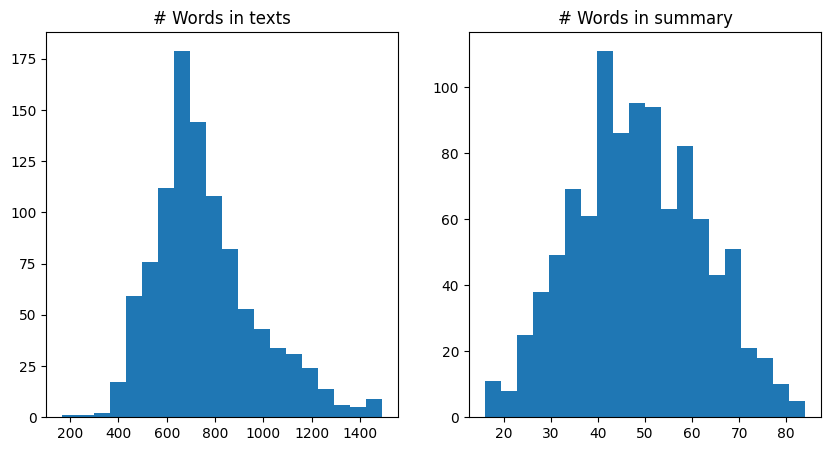

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

## Lead-3

In [14]:
!pip install rouge==0.3.1

In [15]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

In [23]:
import razdel

def calc_lead_n_score(records, n=3, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        sentences = [sentence.text for sentence in razdel.sentenize(text)]
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)

    calc_scores(references, predictions)

calc_lead_n_score(test_records, n=1)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области.
BLEU:  0.19177311186434495
ROUGE:  {'rouge-1': {'f': 0.23804097238957525, 'p': 0.22208274285774904, 'r': 0.37762764047433917}, 'rouge-2': {'f': 0.10027796832321115, 'p': 0.09647636782929753, 'r': 0.15833772153385062}, 'rouge-l': {'f': 0.1835646488408507, 'p': 0.2022959168891477, 'r': 0.34937017731940756}}


## Метод Луна

In [24]:
# Делаем предобработку

import razdel
import spacy

# Список частей речи, которые мы не хотим считать значимыми.
# Подбирался на глаз.
BAD_POS = ("PREP", "NPRO", "CONJ", "PRCL", "NUMR", "PRED", "INTJ", "PUNCT", "CCONJ", "ADP", "DET", "ADV")

# Загрузка модели для частеречной разметки.
spacy_model = spacy.load("ru_core_news_md")


# Метод для разбиения текста на предложения.
def sentenize(text):
    return [s.text for s in razdel.sentenize(text)]


# Метод для токенизации предложения.
def tokenize_sentence(sentence):
    sentence = sentence.strip().replace("\xa0", "")
    tokens = [token.lemma_ for token in spacy_model(sentence) if token.pos_ not in BAD_POS]
    tokens = [token for token in tokens if len(token) > 2]
    return tokens


# Метод для токенизации всего текста.
def tokenize_text(text):
    all_tokens = []
    for sentence in sentenize(text):
        all_tokens.extend(tokenize_sentence(sentence))
    return all_tokens


# Пример работы обоих методов.
text = test_records[0]["text"]
sentences = sentenize(text)
print(tokenize_sentence(sentences[0]))
print(tokenize_text(text))

['американский', 'аэрокосмический', 'агентство', 'nasa', 'огласить', 'название', 'четыре', 'космический', 'миссия', 'которые', 'скорый', 'время', 'мочь', 'быть', 'выбрать', 'реализация', 'запуск', 'которых', 'мочь', 'состояться', 'конец', 'десятилетие']
['американский', 'аэрокосмический', 'агентство', 'nasa', 'огласить', 'название', 'четыре', 'космический', 'миссия', 'которые', 'скорый', 'время', 'мочь', 'быть', 'выбрать', 'реализация', 'запуск', 'которых', 'мочь', 'состояться', 'конец', 'десятилетие', 'четыре', 'проект', 'стать', 'полуфиналист', 'конкурс', 'объявить', 'американский', 'научный', 'команда', 'котором', 'участвовать', 'десять', 'миссия', 'они', 'были', 'отобрать', 'критерий', 'потенциальный', 'польза', 'наука', 'технический', 'осуществимость', 'проект', 'рамка', 'программа', 'discovery', 'nasa', 'заниматься', 'планирование', 'миссия', 'которые', 'призваны', 'дать', 'ответ', 'фундаментальный', 'вопрос', 'происхождение', 'тело', 'солнечный', 'система', 'возможный', 'наличие

In [25]:
from collections import Counter

class LuhnSummarizer:
    """
    Метод Луна.
    Основано на https://github.com/miso-belica/sumy/blob/main/sumy/summarizers/luhn.py
    Оригинальная статья: https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf
    """
    def __init__(
        self,
        significant_percentage = 0.4, # 40% самых частотных токенов мы считаем значимыми.
        min_token_freq = 2, # Кроме того, слова должны встречаться минимум 2 раза.
        max_gap_size = 4, # Максимальное количество подряд идущих незначимых токенов в промежутках.
        verbose = False # Отладочный вывод для наглядности.
    ):
        self.significant_percentage = significant_percentage
        self.min_token_freq = min_token_freq
        self.max_gap_size = max_gap_size
        self.chunk_ending_mask = [0] * self.max_gap_size
        self.verbose = verbose

    def __call__(self, text, target_sentences_count):
        # Считаем значимые токены.
        all_significant_tokens = self._get_significant_tokens(text)
        if self.verbose:
            print("Значимые токены: ", all_significant_tokens)

        # Считаем значимости предложений.
        ratings = []
        for sentence_index, sentence in enumerate(sentenize(text)):
            # Значимость предложений - максимум из значимостей промежутков.
            sentence_rating = max(self._get_chunk_ratings(sentence, all_significant_tokens))
            if self.verbose:
                print("\tПРЕДЛОЖЕНИЕ. Значимость: {}, текст: {}".format(sentence_rating, sentence))
            ratings.append((sentence_rating, sentence_index))

        # Сортируем предложения по значимости.
        ratings.sort(reverse=True)

        # Оставляем топовые и собираем реферат.
        ratings = ratings[:target_sentences_count]
        indices = [index for _, index in ratings]
        indices.sort()
        return " ".join([sentences[index] for index in indices])

    def _get_significant_tokens(self, text):
        """ Метод для подсчёта того, какие токены являются значимыми. """
        tokens_counter = Counter(tokenize_text(text))
        significant_tokens_max_count = int(len(tokens_counter) * self.significant_percentage)
        significant_tokens = tokens_counter.most_common(significant_tokens_max_count)
        significant_tokens = {token for token, cnt in significant_tokens if cnt >= self.min_token_freq}
        return significant_tokens

    def _get_chunk_ratings(self, sentence, significant_tokens):
        """ Разбиваем предложение на промежтуки и считаем их значимости. """

        tokens = tokenize_sentence(sentence)

        chunks, masks = [], []
        in_chunk = False
        for token in tokens:
            is_significant_token = token in significant_tokens

            if is_significant_token and not in_chunk:
                in_chunk = True
                masks.append([int(is_significant_token)])
                chunks.append([token])
            elif in_chunk:
                last_mask = masks[-1]
                last_mask.append(int(is_significant_token))
                last_chunk = chunks[-1]
                last_chunk.append(token)
            if not chunks:
                continue

            # Проверяем на наличие 4 подряд идущих незначимых токенов.
            # Если встретили - завершаем промежуток.
            last_chunk_ending_mask = masks[-1][-self.max_gap_size:]
            if last_chunk_ending_mask == self.chunk_ending_mask:
                in_chunk = False

        ratings = []
        for chunk, mask in zip(chunks, masks):
            rating = self._get_chunk_rating(mask, chunk)
            ratings.append(rating)
        return ratings

    def _get_chunk_rating(self, original_mask, chunk):
        """ Подсчёт значимости одного промежутка """

        # Убираем незначимые токены в конце промежутка
        original_mask = "".join(map(str, original_mask))
        mask = original_mask.rstrip("0")

        end_index = original_mask.rfind("1") + 1
        chunk = chunk[:end_index]
        assert len(mask) == len(chunk)
        chunk = " ".join(chunk)

        # Считаем значимость
        words_count = len(mask)
        assert words_count > 0
        significant_words_count = mask.count("1")
        assert significant_words_count > 0

        rating = significant_words_count * significant_words_count / words_count
        if self.verbose:
            print("ПРОМЕЖУТОК. Значимость: {}, маска: {}, текст: {}".format(rating, mask, chunk))
        return rating

In [ ]:
luhn = LuhnSummarizer(verbose=False)
summary = luhn(text, 3)
print()
print(f"Текст: {test_records[0]['text']}")
print(f"Итоговый реферат: {summary}")
print(f"Правильный реферат: {test_records[0]['summary']}")


Текст: Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, как они и им подобные объекты образовались в космосе». Каждый проект из 

## TextRank

https://habr.com/ru/post/455762/

In [ ]:
from itertools import combinations
import networkx as nx
import pymorphy2
import numpy as np
from tqdm.notebook import tqdm

def unique_words_similarity(words1, words2):
    '''
    Функция подсчёта близости предложений на основе пересечения слов
    '''
    words1 = set(words1)
    words2 = set(words2)
    if not len(words1) or not len(words2):
        return 0.0
    return len(words1.intersection(words2)) / (len(words1) + len(words2))
    #return len(words1.intersection(words2)) / (np.log10(len(words1)) + np.log10(len(words2)))

def gen_text_rank_summary(text, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, morph=None):
    '''
    Составление summary с помощью TextRank
    '''
    # Разбиваем текст на предложения
    sentences = [sentence.text for sentence in razdel.sentenize(text)]
    n_sentences = len(sentences)

    # Токенизируем предложения
    sentences_words = [[token.text.lower() if lower else token.text for token in razdel.tokenize(sentence)] for sentence in sentences]

    # При необходимости лемматизируем слова
    if morph is not None:
        sentences_words = [[morph.parse(word)[0].normal_form for word in words] for words in sentences_words]

    # Для каждой пары предложений считаем близость
    pairs = combinations(range(n_sentences), 2)
    scores = [(i, j, calc_similarity(sentences_words[i], sentences_words[j])) for i, j in pairs]

    # Строим граф с рёбрами, равными близости между предложениями
    g = nx.Graph()
    g.add_weighted_edges_from(scores)

    # Считаем PageRank

    pr = nx.pagerank(g)
    result = [(i, pr[i], s) for i, s in enumerate(sentences) if i in pr]
    result.sort(key=lambda x: x[1], reverse=True)

    # Выбираем топ предложений
    n_summary_sentences = max(int(n_sentences * summary_part), 1)
    result = result[:n_summary_sentences]
    #BLEU:  0.531336150784986

    # Восстанавливаем оригинальный их порядок
    result.sort(key=lambda x: x[0])

    num_sents = len(result)
    # Восстанавливаем текст выжимки
    predicted_summary = " ".join([sentence for i, proba, sentence in result])
    predicted_summary = predicted_summary.lower() if lower else predicted_summary
    return predicted_summary, num_sents

def calc_text_rank_score(records, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, nrows=1000, morph=None):
    references = []
    predictions = []
    length_sents = []

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, num_sents = gen_text_rank_summary(text, calc_similarity, summary_part, lower, morph=morph)
        length_sents.append(num_sents)
        text = text if not lower else text.lower()
        predictions.append(predicted_summary)

    print(f'Mean number of sents in summary: {np.mean(length_sents)}')
    calc_scores(references, predictions)

morph = pymorphy2.MorphAnalyzer()
calc_text_rank_score(test_records)

0it [00:00, ?it/s]

Mean number of sents in summary: 3.276
Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: в комментарии также отмечается, что это беспрецедентный подобный проект на телевидении. съемки начнутся уже в ноябре», — указывается в анонсе. от «зенита» до «спартака», — сказал священник. в июне нынешнего года сообщалось, что рпц планирует сделать из сергиева посада «православный ватикан».
BLEU:  0.3508755059541153
ROUGE:  {'rouge-1': {'f': 0.15466400887322831, 'p': 0.16298929023222172, 'r': 0.15602281048791292}, 'rouge-2': {'f': 0.030615979709094604, 'p': 0.031077035455225686, 'r': 0.032019614611385826}, 'rouge-l': {'f': 0.13373567967669006, 'p': 0.14775573752428653, 'r': 0.1

Сделаем TextRank с другой мерой близости предложений: по FastText, ELMo или BERT эмбеддингам

In [16]:
!pip install navec

In [17]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

--2023-09-18 04:58:46--  https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26634240 (25M) [application/x-tar]
Saving to: ‘navec_news_v1_1B_250K_300d_100q.tar’

navec_news_v1_1B_25 100%[===================>]  25.40M  9.72MB/s    in 2.6s    

2023-09-18 04:58:49 (9.72 MB/s) - ‘navec_news_v1_1B_250K_300d_100q.tar’ saved [26634240/26634240]



In [18]:
from navec import Navec

path = '/content/navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)

In [19]:
from numpy.linalg import norm
def vectorize_sum(words, embeddings):

    embedding_dim = embeddings['example'].shape[0]
    features = np.zeros([embedding_dim], dtype='float32')

    num_known_words = 0
    for word in words:
        if word in embeddings:
            num_known_words += 1
            features += embeddings[f'{word}']

    if num_known_words:
        return features / num_known_words
    else: return features

def my_sim(text1, text2, embeddings=navec, kind='cos'):

    v1, v2 = vectorize_sum(text1, embeddings), vectorize_sum(text2, embeddings)
    if np.sum(v1) == 0.0 or np.sum(v2) == 0.0:
        return 0

    return np.abs(np.dot(v1, v2) / norm(v1) / norm(v2))

In [ ]:
calc_text_rank_score(test_records, calc_similarity=my_sim, morph=morph)

0it [00:00, ?it/s]

Mean number of sents in summary: 3.276
Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: «у нас же даже многие журналисты не знают и не понимают многого, связанного с религиозными ценностями, а здесь — попытка обратить их внимание на это, может быть, им будет интересно. и это что — жизнь, что ли? «если человеку невоцерковленному, далекому от церкви, в двух словах сказать, для чего нужна церковь — церковь… нужна для того, чтобы был силен дух нашего народа», — говорил предстоятель. по словам патриарха, им станет тот, кто будет стоять «во главе всемирной паутины».
BLEU:  0.2736838350215274
ROUGE:  {'rouge-1': {'f': 0.15109432683062032, 'p': 0.12445104194115493, 'r': 0.

## Lexrank
* Original paper: https://arxiv.org/pdf/1109.2128.pdf
* lexrank library: https://github.com/crabcamp/lexrank

In [28]:
def calc_method_score(records, predict_func, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if nrows is not None and i >= nrows:
            break
        summary = record["summary"]
        text = record["text"]
        prediction = predict_func(text, summary)
        references.append(summary)
        predictions.append(prediction)

    calc_scores(references, predictions)

In [20]:
!pip install lexrank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.9 MB/s eta 0:00:00


In [ ]:
import lexrank
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS


def predict_lex_rank(text, summary, lxr, summary_size=3, threshold=None):
    sentences = [s.text for s in razdel.sentenize(text)]
    prediction = lxr.get_summary(sentences, summary_size=summary_size, threshold=threshold)
    prediction = " ".join(prediction)
    return prediction


sentences = [[s.text for s in razdel.sentenize(r["text"])] for r in test_records]
lxr = LexRank(sentences, stopwords=STOPWORDS['ru'])
calc_method_score(test_records, lambda x, y: predict_lex_rank(x, y, lxr))

Count: 1000
Ref: Телеканал «Спас» запускает реалити-шоу «Остров», участникам которого предстоит месяц жить и работать в Нило-Столобенской пустыни на озере Селигер. Организаторы отметили, что это беспрецедентный подобный проект на телевидении. Участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: РПЦ же нередко критикует СМИ. Критиковали в РПЦ и популярность футбола – об этом заявлял также Смирнов. В июне нынешнего года сообщалось, что РПЦ планирует сделать из Сергиева Посада «православный Ватикан».
BLEU:  0.3585872220880093
ROUGE:  {'rouge-1': {'f': 0.1866598392888999, 'p': 0.18137864753781832, 'r': 0.2055701577098893}, 'rouge-2': {'f': 0.05775558829470266, 'p': 0.05407660852215697, 'r': 0.06670656927927147}, 'rouge-l': {'f': 0.16173754022433068, 'p': 0.16619633248764337, 'r': 0.18766952121068614}}


LSA
 - One of the original papers: https://www.cs.bham.ac.uk/~pxt/IDA/text_summary.pdf
 - sumy library: https://github.com/miso-belica/sumy

In [29]:
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
import nltk; nltk.download('punkt');


def predict_lsa(text, summary, lsa_summarizer, tokenizer, summary_size=3):
    parser = PlaintextParser.from_string(text, tokenizer)
    predicted_summary = lsa_summarizer(parser.document, summary_size)
    predicted_summary = " ".join([str(s) for s in predicted_summary])
    return predicted_summary

lsa_summarizer = LsaSummarizer()
tokenizer = Tokenizer("russian")
calc_method_score(test_records, lambda x, y: predict_lsa(x, y, lsa_summarizer, tokenizer))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Count: 1000
Ref: Телеканал «Спас» запускает реалити-шоу «Остров», участникам которого предстоит месяц жить и работать в Нило-Столобенской пустыни на озере Селигер. Организаторы отметили, что это беспрецедентный подобный проект на телевидении. Участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: Известный миссионер, председатель Синодального отдела МП по взаимодействию с Вооруженными силами и правоохранительными учреждениями протоиерей Дмитрий Смирнов выразил надежду, что проект даст благие результаты. Стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека. По его словам, такая зависимость сродни алкогольной или наркотической — электронные устройства лишают человека свободы и приводят к «дегуманизации» личности, уводя в виртуальную реальность.
BLEU:  0.2892955231982035
ROUGE:  {'rouge-1': {'f': 0.14328142173967515, 'p

### Summa

In [30]:
from summa.summarizer import summarize

def calc_summa_score(records, summary_part=0.1, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        predicted_summary = summarize(text, ratio=summary_part, language='russian').replace("\n", " ")
        predictions.append(predicted_summary)

    calc_scores(references, predictions)

calc_summa_score(test_records)

0it [00:00, ?it/s]

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. «у нас же даже многие журналисты не знают и не понимают многого, связанного с религиозными ценностями, а здесь — попытка обратить их внимание на это, может быть, им будет интересно. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека. и это что — жизнь, что ли?
BLEU:  0.2762958192799957
ROUGE:  {'rouge-1': {'f': 0.1770425497877709, 'p': 0.14391909693539454, 'r': 0.247378763312854

## Oracle summary

Для сведения задачи к extractive summarization мы должны выбрать те предложения из оригинального текста, которые наиболее похожи на наше целевое summary по нашим метрикам.

In [31]:
import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()

    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

In [32]:
from tqdm.notebook import tqdm
import razdel

def calc_oracle_score(records, nrows=1000, lower=True):
    references = []
    predictions = []
    rouge = Rouge()

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, _ = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge))
        predictions.append(predicted_summary)

    calc_scores(references, predictions)


calc_oracle_score(test_records)

0it [00:00, ?it/s]

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области. в комментарии также отмечается, что это беспрецедентный подобный проект на телевидении. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
BLEU:  0.531336150784986
ROUGE:  {'rouge-1': {'f': 0.36951810858804146, 'p': 0.4053281117404892, 'r': 0.3661389123393327}, 'rouge-2': {'f': 0.2087846693590

## RNN

In [33]:
import pandas as pd
df_train = pd.DataFrame(train_records)
df_test = pd.DataFrame(test_records)

In [34]:
df_train.head(5)

,url,text,title,summary,date
0,https://www.gazeta.ru/financial/2011/11/30/385...,«По итогам 2011 года чистый отток может состав...,Прогноз не успевает за оттоком,"В 2011 году из России уйдет $80 млрд, считают ...",2011-11-30 18:33:39
1,https://www.gazeta.ru/business/2013/01/24/4939...,Российское подразделение интернет-корпорации G...,Google закончил поиск,"Юлия Соловьева, экс-директор холдинга «Профмед...",2013-01-24 18:20:09
2,https://www.gazeta.ru/social/2018/02/06/116393...,Басманный районный суд Москвы вечером 6 феврал...,«Фигуранты дела могут давить на свидетелей»,Суд арестовал на два месяца четверых экс-чинов...,2018-02-06 21:21:14
3,https://www.gazeta.ru/business/2013/06/21/5388...,Как повлияло вступление в ВТО на конкурентносп...,«С последних традиционно «отжимают» больше»,Мнения предпринимателей по поводу вступления в...,2013-06-21 17:43:50
4,https://www.gazeta.ru/culture/2014/12/27/a_636...,К третьему сезону «Голос» на Первом канале ста...,Третий «Голос» за Градского,На Первом канале завершился третий сезон шоу «...,2014-12-27 01:10:01


In [35]:
df_test.head(5)

,url,text,title,summary,date
0,https://www.gazeta.ru/science/2020/02/14_a_129...,Американское аэрокосмическое агентство NASA ог...,"Венера, Ио или Тритон: куда полетит NASA","В NASA назвали четыре миссии в дальний космос,...",2020-02-14 16:39:11
1,https://www.gazeta.ru/social/2020/02/28/129806...,Около 11 тысяч зрителей увидели все самое лучш...,«Люди в Бурятии очень талантливые»,25 и 26 февраля в Кремлевском дворце съездов п...,2020-02-28 10:44:13
2,https://www.gazeta.ru/politics/2019/11/07_a_12...,7 ноября в Белоруссии прошли выборы членов сов...,Вспомнить СССР: как Лукашенко провел выборы,В Белоруссии в день годовщины Октябрьской рево...,2019-11-07 19:55:08
3,https://www.gazeta.ru/culture/2020/03/01/a_129...,Народная артистка РСФСР Надежда Бабкина в инте...,«Он очень переживал»: Бабкина об отношениях с ...,Народная артистка РСФСР Надежда Бабкина в инте...,2020-03-01 16:50:06
4,https://www.gazeta.ru/business/2020/02/06/1294...,Депутат Верховной рады от партии «Слуга народа...,«Поддерживают Россию»: почему Киев не платит п...,Украина не должна выплачивать пенсии жителям Д...,2020-02-06 12:41:24


In [36]:
df_train['summary_clean'] = df_train['summary'].apply(lambda v: 'BOS ' + v + ' EOS')
df_test['summary_clean'] = df_test['summary'].apply(lambda v: 'BOS ' + v + ' EOS')
df_train['summary_clean'][:5]

0    BOS В 2011 году из России уйдет $80 млрд, счит...
1    BOS Юлия Соловьева, экс-директор холдинга «Про...
2    BOS Суд арестовал на два месяца четверых экс-ч...
3    BOS Мнения предпринимателей по поводу вступлен...
4    BOS На Первом канале завершился третий сезон ш...
Name: summary_clean, dtype: object

In [37]:
MAX_TRAIN_SAMPLE = 1000
MAX_TEST_SAMPLE = 200

df_train = df_train[:MAX_TRAIN_SAMPLE]
df_test = df_test[:MAX_TEST_SAMPLE]

In [40]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
max_len_text = 700
max_len_sum = 70

In [42]:
#tok_text = Tokenizer(oov_token='UNK')
tok_text = Tokenizer()
tok_text.fit_on_texts(df_train['text'])
x_train_tok = tok_text.texts_to_sequences(df_train['text'])
x_test_tok = tok_text.texts_to_sequences(df_test['text'])

In [43]:
text_vocab_size = len(tok_text.word_index) + 1

padded_x_train = pad_sequences(x_train_tok, maxlen=max_len_text, padding='post', truncating='post')
padded_x_test = pad_sequences(x_test_tok, maxlen=max_len_text, padding='post', truncating='post')

In [44]:
#tok_sum = Tokenizer(oov_token='UNK')
tok_sum = Tokenizer()
tok_sum.fit_on_texts(df_train['summary_clean'])
x_train_sum = tok_sum.texts_to_sequences(df_train['summary_clean'])
x_test_sum = tok_sum.texts_to_sequences(df_test['summary_clean'])

sum_vocab_size=len(tok_sum.word_index)+1

padded_x_train_sum = pad_sequences(x_train_sum, maxlen=max_len_sum, padding='post', truncating='post')
padded_x_test_sum = pad_sequences(x_test_sum, maxlen=max_len_sum, padding='post', truncating='post')

In [45]:
padded_x_train_sum.shape

(1000, 70)

In [46]:
padded_x_test_sum.shape

(200, 70)

In [57]:
reverse_text_index=tok_text.index_word
reverse_sum_index=tok_sum.index_word
sum_wordindex=tok_sum.word_index

### Model

In [47]:
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, TimeDistributed, Softmax, Dense, RepeatVector, Concatenate, Dense
from tensorflow.keras.models import Model

In [48]:
latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_len_text,))

#embedding layer
enc_emb =  Embedding(text_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,return_state=True,dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) #encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(sum_vocab_size, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(sum_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 700)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 700, 200)             1766400   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 700, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                    

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [50]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [52]:
history = model.fit([padded_x_train, padded_x_train_sum[:,:-1]], padded_x_train_sum.reshape(padded_x_train_sum.shape[0],padded_x_train_sum.shape[1], 1)[:,1:],
                    epochs=5,
                    validation_data=([padded_x_test, padded_x_test_sum[:,:-1]], padded_x_test_sum.reshape(padded_x_test_sum.shape[0], padded_x_test_sum.shape[1], 1)[:,1:]),
                    batch_size=16)

Epoch 1/5
63/63 [==============================] - 644s 10s/step - loss: 6.0640 - accuracy: 0.3833 - val_loss: 4.2000 - val_accuracy: 0.4953
Epoch 2/5
63/63 [==============================] - 614s 10s/step - loss: 5.2920 - accuracy: 0.3968 - val_loss: 3.9028 - val_accuracy: 0.5247
Epoch 3/5
63/63 [==============================] - 599s 10s/step - loss: 5.0976 - accuracy: 0.4093 - val_loss: 3.8913 - val_accuracy: 0.5307
Epoch 4/5
63/63 [==============================] - 587s 9s/step - loss: 4.9965 - accuracy: 0.4153 - val_loss: 3.8915 - val_accuracy: 0.5310
Epoch 5/5
63/63 [==============================] - 590s 9s/step - loss: 4.9361 - accuracy: 0.4147 - val_loss: 3.9068 - val_accuracy: 0.5307


In [58]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [59]:
import numpy as np

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = sum_wordindex['bos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_sum_index[sampled_token_index]

        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (max_len_sum - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [60]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=sum_wordindex['bos']) and i!=sum_wordindex['eos']):
            newString=newString+reverse_sum_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_text_index[i]+' '
    return newString


In [61]:
for i in range(0, 3):
    #print("Review:",seq2text(padded_x_test[i]))
    print("Original summary:",seq2summary(padded_x_test_sum[i]))

    print("Predicted summary:",decode_sequence(padded_x_test[i].reshape(1, max_len_text)))
    print("\n")

Original summary: в nasa назвали четыре миссии в космос которые в этом могут быть американцами среди них — две миссии по полет к и к 
1/1 [==============================] - 0s 23ms/step
Predicted summary:  в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в первом первом мигалкой tpg tpg ситуациями ситуациями ситуациями ситуациями плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить плодить


Original summary: 25 и 26 февраля в праздновали — новый год центр российского и один из регионов страны где новый год официально дважды 
1/1 [==============================] - 0s 22ms/step
Predicted summary:  в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в первом первом мигалкой tpg tpg ситуациями ситуациями ситуациями ситуациями плодить плодить плодить плодить плодить плодить плодить плодить плодить п

## Attention

In [62]:
from tensorflow.keras.layers import GRU, AdditiveAttention

In [63]:
BUFFER_SIZE = len(padded_x_train)
BATCH_SIZE = 32
steps_per_epoch = len(padded_x_train)//BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((padded_x_train, padded_x_train_sum)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [64]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 700]), TensorShape([32, 70]))

In [65]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.gru2 = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru1(x, initial_state = hidden)
        output, state = self.gru2(output, initial_state = state)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, x, query, value):
        # enc_output shape == (batch_size, max_length, hidden_size)
        #attention_weights = self.attention([ tf.expand_dims(query, 1), value,])
        context_vector = self.attention([tf.expand_dims(query, 1), value,])
        #context_vector = tf.squeeze(context_vector)


        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([context_vector, x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [66]:
latent_dim = 300
embedding_dim=200

In [67]:
encoder = Encoder(text_vocab_size, embedding_dim, latent_dim, BATCH_SIZE)
decoder = Decoder(sum_vocab_size, embedding_dim, latent_dim, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [68]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [69]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([sum_wordindex['bos']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [70]:
import unicodedata
import re
import numpy as np
import os
import io
import time

In [71]:
checkpoint_dir = './training_summ_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [72]:
EPOCHS = 100

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 10 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # saving (checkpoint) the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.6950
Epoch 1 Batch 10 Loss 5.2733
Epoch 1 Batch 20 Loss 5.0074
Epoch 1 Batch 30 Loss 5.1071
Epoch 1 Loss 5.5506
Time taken for 1 epoch 111.25273942947388 sec

Epoch 2 Batch 0 Loss 5.4416
Epoch 2 Batch 10 Loss 5.7280
Epoch 2 Batch 20 Loss 5.1770
Epoch 2 Batch 30 Loss 5.3500
Epoch 2 Loss 5.1680
Time taken for 1 epoch 20.141221046447754 sec

Epoch 3 Batch 0 Loss 4.8924
Epoch 3 Batch 10 Loss 4.6727
Epoch 3 Batch 20 Loss 4.9726
Epoch 3 Batch 30 Loss 5.3734
Epoch 3 Loss 5.0550
Time taken for 1 epoch 20.468279361724854 sec

Epoch 4 Batch 0 Loss 4.9954
Epoch 4 Batch 10 Loss 4.8401
Epoch 4 Batch 20 Loss 4.8597
Epoch 4 Batch 30 Loss 5.1164
Epoch 4 Loss 4.9668
Time taken for 1 epoch 17.964210510253906 sec

Epoch 5 Batch 0 Loss 4.7128
Epoch 5 Batch 10 Loss 5.0407
Epoch 5 Batch 20 Loss 4.9058
Epoch 5 Batch 30 Loss 5.3980
Epoch 5 Loss 4.9168
Time taken for 1 epoch 20.470097541809082 sec

Epoch 6 Batch 0 Loss 4.7887
Epoch 6 Batch 10 Loss 4.4967
Epoch 6 Batch 20 Loss 5.1332
Epoc

In [73]:
def evaluate(sentence):
    inputs = [tok_text.word_index[i] for i in sentence.split(' ') if i !='']
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_len_text,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    hidden = [tf.zeros((1, latent_dim))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tok_sum.word_index['bos']], 0)

    for t in range(max_len_sum):
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out)

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tok_sum.index_word[predicted_id] + ' '

        if tok_sum.index_word[predicted_id] == 'eos':
            return result, sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [74]:
def summ(sentence):
    result, sentence = evaluate(sentence)

    return result

In [75]:
for i in range(3, 6):
    text2 = seq2text(padded_x_test[i])
    #print("Review:",seq2text(padded_x_test[i]))
    print("Original summary:", seq2summary(padded_x_test_sum[i]))
    print("Predicted summary: ", summ(text2.strip()))
    print("\n")

Original summary: народная артистка надежда в интервью рассказала о своей жизни в частности певица почему ее муж по поводу об их отношениях а также не смогла сдержать о смерти младшего 
Predicted summary:  президент украины петр порошенко «не хотел срывать президентские выборы» назначенные на протяжении уже не посещает свой отель в нем со времен вхождения полуострова в нем со времен вхождения полуострова в нем со времен вхождения полуострова в нем со времен вхождения полуострова в нем со времен вхождения полуострова в нем со времен вхождения полуострова в нем со времен вхождения полуострова в нем со времен вхождения полуострова в нем со времен вхождения 


Original summary: украина не должна выплачивать пенсии и лнр поскольку они могут поддерживать россию заявила депутат верховной рады от партии елизавета она выступила против закона о праве на получение от государства для жителей донбасса по ее словам это в сторону тех кто уехал на украину и ничего не получил 
Predicted summary:  в 7 8

Получается смешной пересказ в переводе гоблина

## mBART huggingface
* BART paper: https://arxiv.org/abs/1910.13461
* mBART paper: https://arxiv.org/abs/2001.08210
* Model: https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta

In [3]:
!pip install transformers

In [4]:
!pip install sentencepiece


In [12]:
from transformers import MBartTokenizer, MBartForConditionalGeneration

model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

article_text = test_records[0]['text']

input_ids = tokenizer(
    [article_text],
    max_length=600,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)["input_ids"]

output_ids = model.generate(
    input_ids=input_ids,
    no_repeat_ngram_size=4)[0]

summary = tokenizer.decode(output_ids, skip_special_tokens=True)
print(summary)


Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости.


In [13]:
len(summary)

309

In [14]:
len(test_records[0]['text'])

3820

In [16]:
test_records[0]['summary']

'В NASA назвали четыре миссии в дальний космос, которые в этом десятилетии могут быть запущены американцами. Среди них — две миссии по изучению Венеры, полет к спутнику Юпитера и экспедиция к Тритону, спутнику Нептуна.'

In [17]:
len(test_records[0]['summary'])

217

In [20]:
import torch
from tqdm.notebook import tqdm

In [21]:
import gc

In [22]:
gc.collect()

176

In [ ]:
def gen_batch(inputs, batch_size):
    batch_start = 0
    while batch_start < len(inputs):
        yield inputs[batch_start: batch_start + batch_size]
        batch_start += batch_size


def predict(
    model_name,
    test_file,
    predictions_file,
    targets_file,
    max_source_tokens_count=600,
    max_target_tokens_count=160,
    use_cuda=True,
    batch_size=4
):
    inputs = []
    targets = []
    for i in range(len(test_records)):
            inputs.append(test_records[i]["text"])
            targets.append(test_records[i]["summary"].replace("\n", " "))

    tokenizer = MBartTokenizer.from_pretrained(model_name)
    device = torch.device("cuda:0") if use_cuda else torch.device("cpu")
    model = MBartForConditionalGeneration.from_pretrained(model_name).to(device)
    predictions = []
    for batch in tqdm(gen_batch(inputs, batch_size)):
        input_ids = tokenizer.prepare_seq2seq_batch(
            batch,
            #src_lang="en_XX",
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=max_source_tokens_count
        )["input_ids"].to(device)
        output_ids = model.generate(
            input_ids=input_ids,
            max_length=max_target_tokens_count + 2,
            no_repeat_ngram_size=3,
            num_beams=5,
            top_k=0
        )
        summaries = tokenizer.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
        predictions.extend(summaries)
    with open(predictions_file, "w") as w:
        for p in predictions:
            w.write(p.strip() + "\n")
    with open(targets_file, "w") as w:
        for t in targets:
            w.write(t.strip() + "\n")

predict("IlyaGusev/mbart_ru_sum_gazeta", "gazeta_test.txt", "predictions.txt", "targets.txt")

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3786: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:377: UserWarning: `do_sample` is set to `

In [ ]:
from google.colab import files
files.download("/content/predictions_file")